In [1]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from training import test_ann, train_ann
import matplotlib.pyplot as plt
import numpy as np
from spieks.network.converter import swap_layers
from spieks.ann.neurons import QCFS

print(f"Using pytorch {torch.__version__}")

DT = 0.1
L = 8
T = float(L)

BS = 128
LR = 1e-3
EPOCHS = 20

# Check if CUDA is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device ({DEVICE})')

Using pytorch 2.5.1
Using device (cuda)


Seeding

In [2]:
SEED = 42

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Define the model

In [3]:
class MNISTModel(nn.Module):
	def __init__(self):
		super(MNISTModel, self).__init__()
		self.flatten = nn.Flatten()
		self.w1 = nn.Linear(28 * 28, 128)
		self.r1 = nn.ReLU()
		self.drop1 = nn.Dropout(0.5)
		self.w2 = nn.Linear(128, 64)
		self.r2 = nn.ReLU()
		self.drop2 = nn.Dropout(0.5)
		self.w3 = nn.Linear(64, 10)

		nn.init.kaiming_uniform_(self.w1.weight, nonlinearity='relu')
		nn.init.kaiming_uniform_(self.w2.weight, nonlinearity='relu')
		nn.init.kaiming_uniform_(self.w3.weight, nonlinearity='relu')

	def forward(self, x):
		x = self.flatten(x)
		x = self.drop1(self.r1(self.w1(x)))
		x = self.drop2(self.r2(self.w2(x)))
		x = self.w3(x)
		return x

Train the base ANN on MNSIT

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_dataset = torchvision.datasets.MNIST(root='./tmp/data/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./tmp/data/', train=False, transform=transform, download=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)

# Check if CUDA is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device ({DEVICE})')

# Initialize model
loss_fn = nn.CrossEntropyLoss()
model = MNISTModel().to(DEVICE)
model = swap_layers(model, nn.ReLU, QCFS, {"Q": L})
model = train_ann(model, train_loader, test_loader, loss_fn, EPOCHS, DEVICE, initial_lr=LR)
print(model)

# Calculate the ANN loss and accuracy
ann_loss, ann_acc = test_ann(model, DEVICE, test_loader, loss_fn=nn.CrossEntropyLoss())
print(f"ANN Loss (CrossEntropy): {ann_loss}")
print(f"ANN Accuracy (CrossEntropy): {ann_acc}")

Using device (cuda)


  0%|          | 0/20 [00:00<?, ?it/s]

MNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (w1): Linear(in_features=784, out_features=128, bias=True)
  (r1): QCFS(Q=8, p0=0.5, v_th=7.96)
  (drop1): Dropout(p=0.5, inplace=False)
  (w2): Linear(in_features=128, out_features=64, bias=True)
  (r2): QCFS(Q=8, p0=0.5, v_th=7.96)
  (drop2): Dropout(p=0.5, inplace=False)
  (w3): Linear(in_features=64, out_features=10, bias=True)
)
ANN Loss (CrossEntropy): 0.5636853346457849
ANN Accuracy (CrossEntropy): 0.8568709935897436


Convert the ANN to an SNN

In [5]:
from spieks.network.converter import Converter
from spieks.neurons import IF
neuron_args = {"dt": DT}
spiking_model = Converter.convert(model, { QCFS: IF }, neuron_args)
print(spiking_model)

SpikingNetwork(
  (net): MNISTModel(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (w1): Linear(in_features=784, out_features=128, bias=True)
    (r1): IF(
      log(dt)=-1, v_r=0.0, v_th=Parameter containing:
      tensor(7.9550, device='cuda:0', requires_grad=True)
    )
    (drop1): Dropout(p=0.5, inplace=False)
    (w2): Linear(in_features=128, out_features=64, bias=True)
    (r2): IF(
      log(dt)=-1, v_r=0.0, v_th=Parameter containing:
      tensor(7.9555, device='cuda:0', requires_grad=True)
    )
    (drop2): Dropout(p=0.5, inplace=False)
    (w3): Linear(in_features=64, out_features=10, bias=True)
  )
)


Evaluate the SNN on classification

In [6]:
from spieks.simulator import Classifier
classifier = Classifier(spiking_model, device=DEVICE)
_, loss_if, accuracy_if = classifier.evaluate_dataset(test_loader, duration=T, b_show_progress=True)
print(f"Final Accuracy: {accuracy_if[-1]}")

  0%|          | 0/78 [00:00<?, ?it/s]

Final Accuracy: 0.7960737347602844


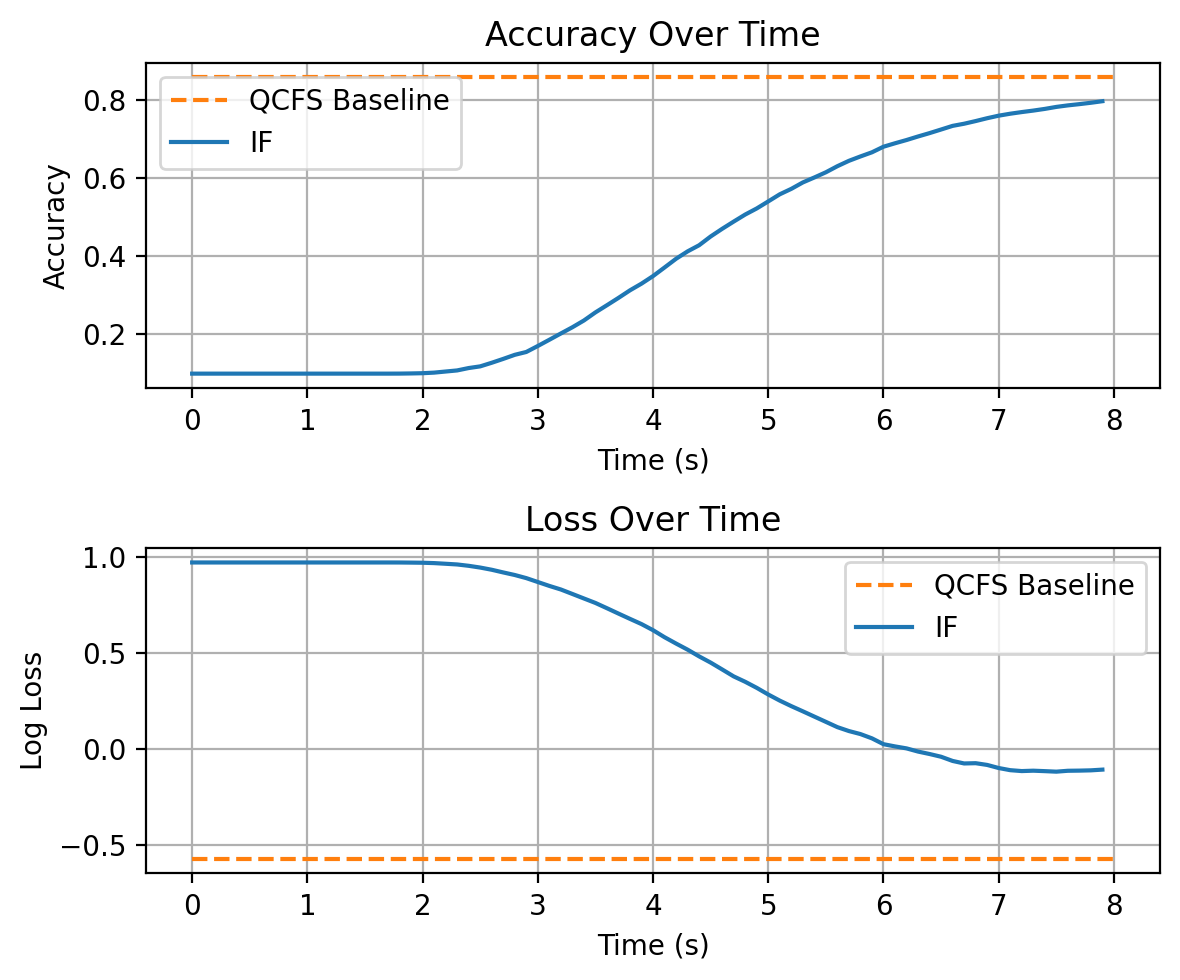

In [7]:
TIME = np.arange(len(accuracy_if)) * DT

fig, axs = plt.subplots(2, 1, figsize=(6, 5), dpi=200)  # Create two subplots stacked vertically

# Accuracy Plot
axs[0].hlines(ann_acc, 0, T, linestyles='--', color='C1', label='QCFS Baseline')
axs[0].plot(TIME, accuracy_if, label='IF', color='C0')
axs[0].set_title("Accuracy Over Time")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Accuracy")
axs[0].grid(True)
axs[0].legend()

# Loss Plot
axs[1].hlines(np.log(ann_loss), 0, T, linestyles='--', color='C1', label='QCFS Baseline')
axs[1].plot(TIME, np.log(loss_if), label='IF', color='C0')
axs[1].set_title("Loss Over Time")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Log Loss")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.savefig('tmp/ann2snn_mnist_plots.png')
plt.show()
